# Dogs vs Cats using CNN 🐶😺🐾

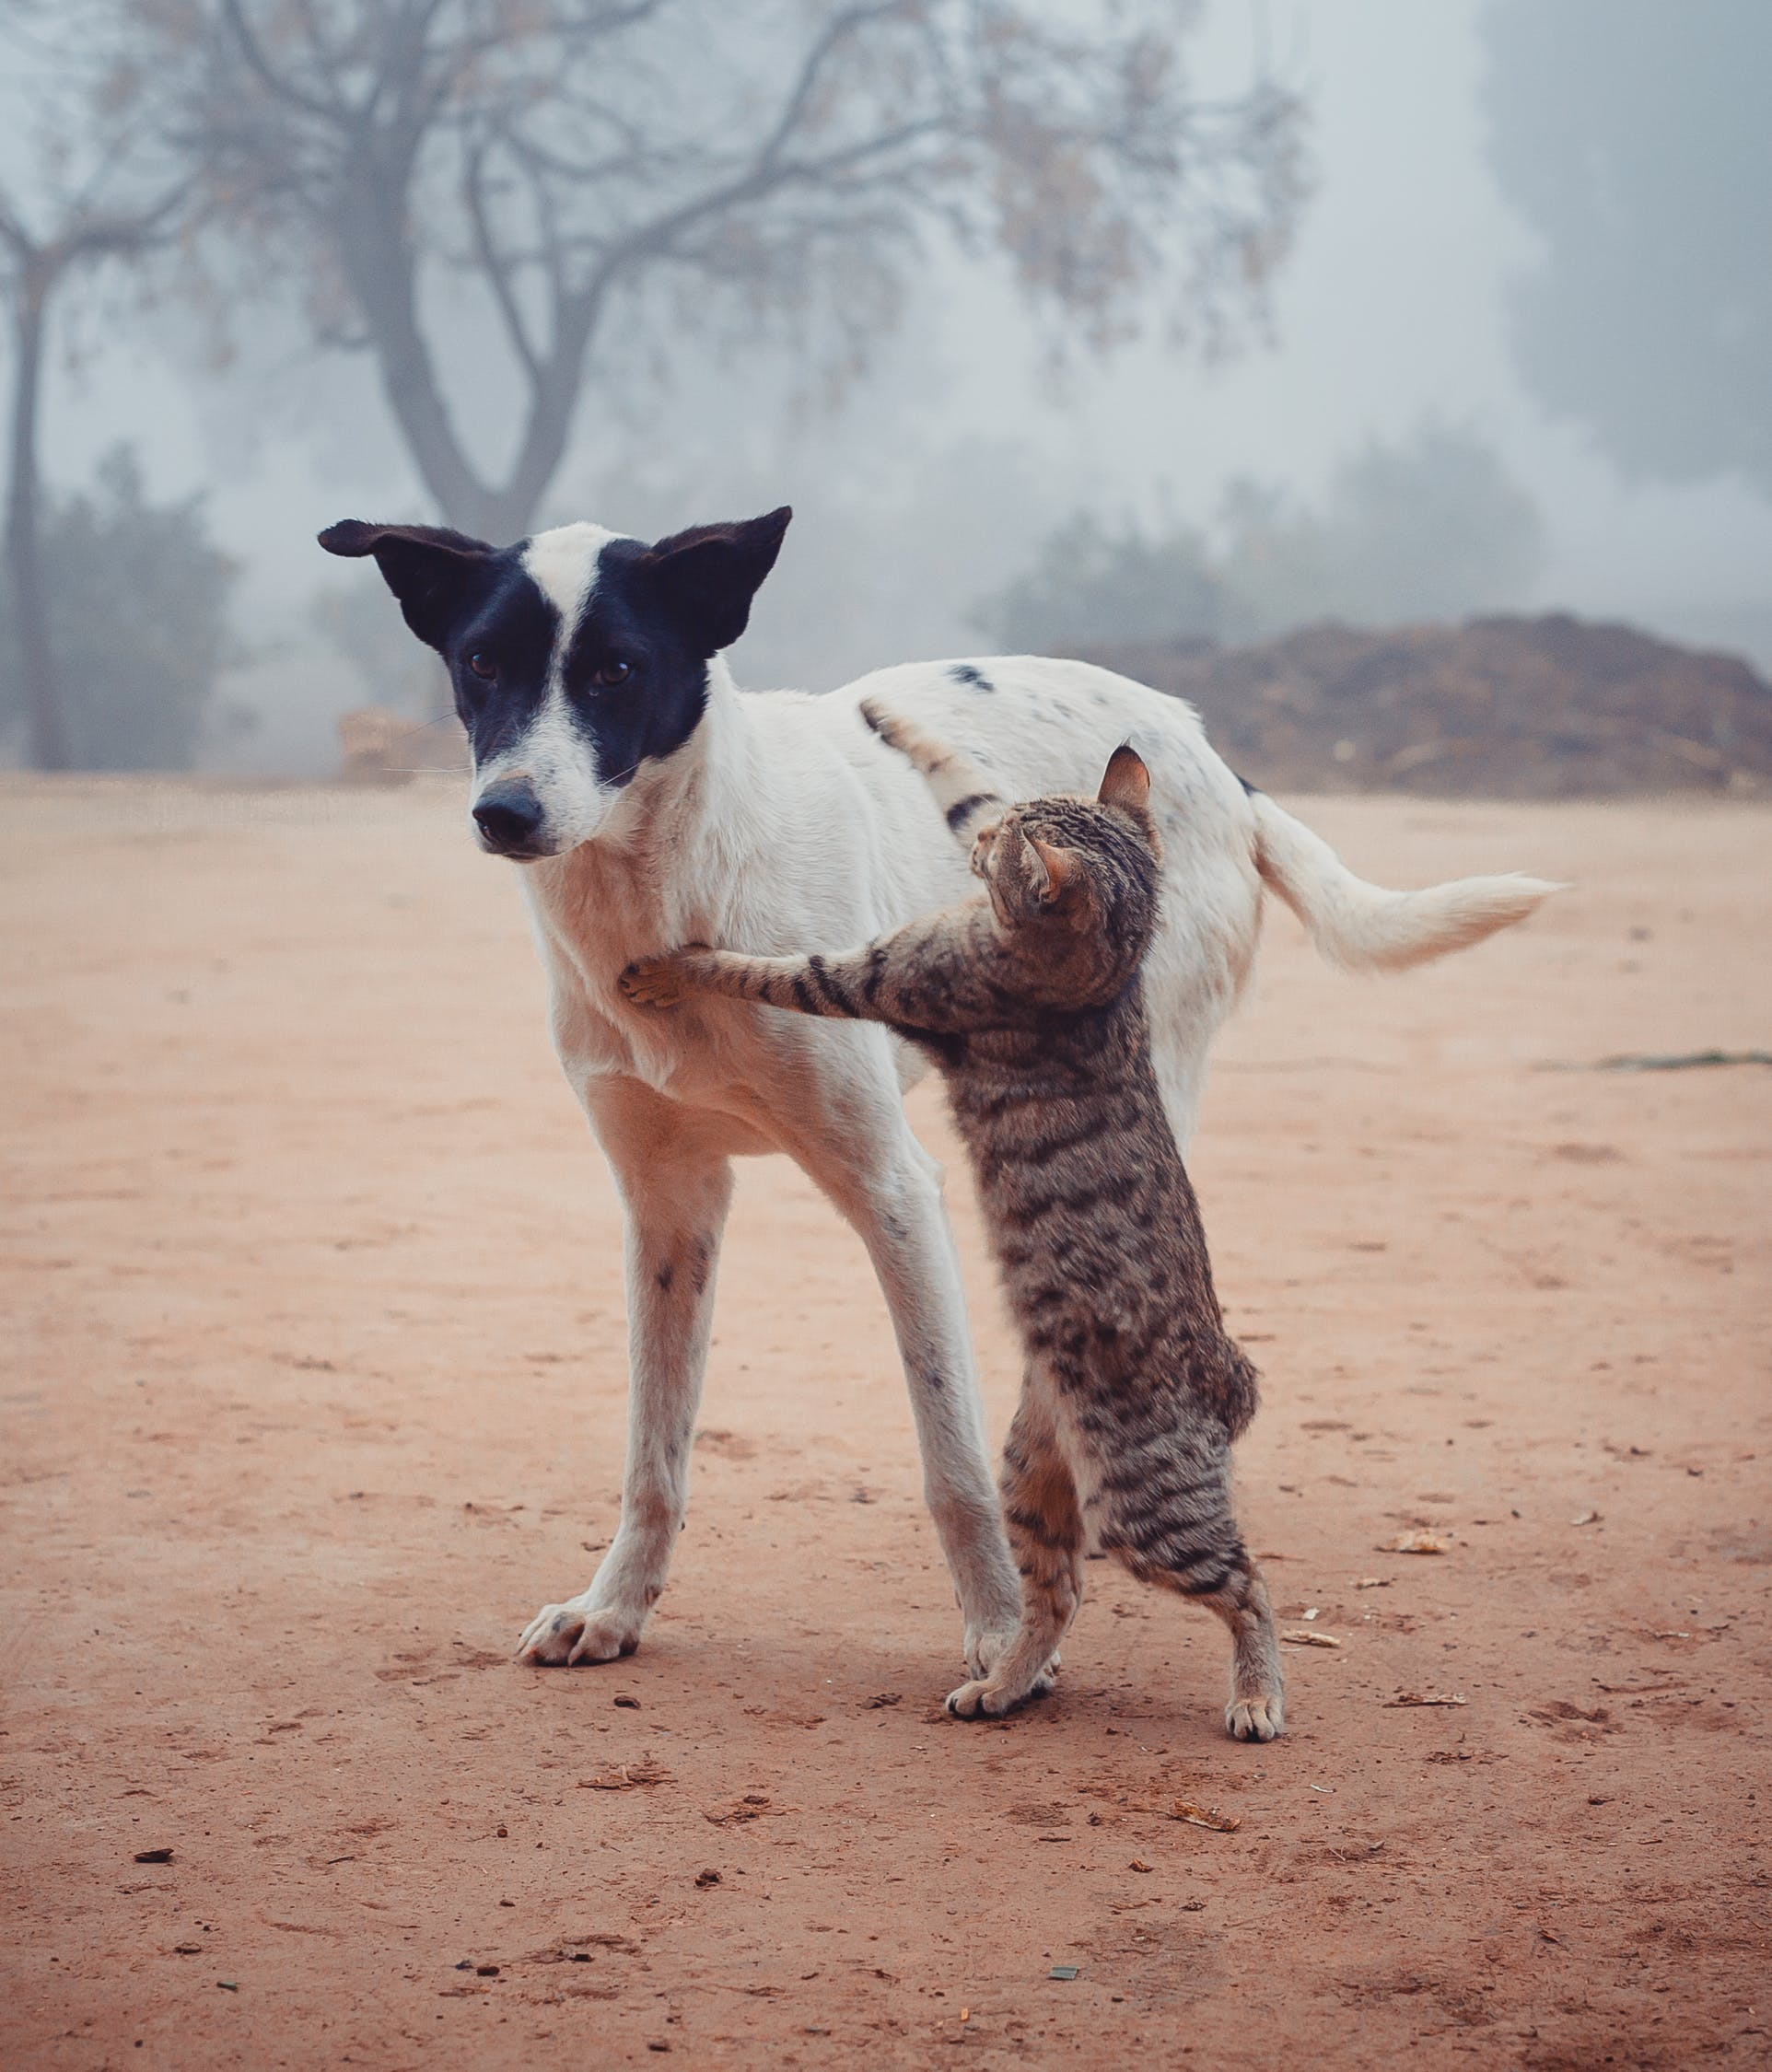

This is an age old problem, but this notebook is written in such a way that suits to answer the following -
- How to unzip the data files and extract it in a folder
- How to sort the data and add it to the folder with the label name
- How to leverage the fact that Image label is taken from the folder name it is stored in, using ImageDataGenerator function
- How to view the outputs of the convolution as well as the maxpooling layers used


In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tqdm
import shutil

In [ ]:
zip_ref = zipfile.ZipFile("../input/dogs-vs-cats/test1.zip", 'r')
zip_ref.extractall("../tmp/dogs-vs-cats")
zip_ref.close()

In [ ]:
zip_ref = zipfile.ZipFile("../input/dogs-vs-cats/train.zip", 'r')
zip_ref.extractall("../tmp/dogs-vs-cats")
zip_ref.close()

In [ ]:
!ls ../tmp/dogs-vs-cats/

In [ ]:
base_dir = '../tmp/dogs-vs-cats'
train_dir = os.path.join(base_dir, 'train')
testing_dir = os.path.join(base_dir, 'test1')

In [ ]:
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = train_dir + '/'
# plot first few images
for i in range(9):
	# define subplot
    pyplot.subplot(330 + 1 + i)
	# define filename
    filename = folder + 'cat.' + str(i) + '.jpg'
	# load image pixels
    image = imread(filename)
	# plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

In [ ]:
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = train_dir + '/'
# plot first few images
for i in range(9):
	# define subplot
    pyplot.subplot(330 + 1 + i)
	# define filename
    filename = folder + 'dog.' + str(i) + '.jpg'
    
	# load image pixels
    print(filename)
    
    image = imread(filename)
   
	# plot raw pixel data
    pyplot.imshow(image)
    # show the figure

pyplot.show()

In [ ]:
train_file_list = os.listdir('../tmp/dogs-vs-cats/train')
print('Num of images:', len(train_file_list))

dog_filenames = [fn for fn in train_file_list if fn.startswith('dog')]
cat_filenames = [fn for fn in train_file_list if fn.startswith('cat')]

dataset_filenames = train_test_split(
    dog_filenames, cat_filenames, test_size=0.1, shuffle=True, random_state=42
)


train_dog, valid_dog, train_cat, valid_cat  = [fns for fns in dataset_filenames]


train_dog_total, valid_dog_total, train_cat_total, valid_cat_total = [len(fns) for fns in dataset_filenames]
train_total = train_dog_total + train_cat_total
valid_total = valid_dog_total + valid_cat_total
print('Train: {}, test: {}'.format(train_total, valid_total))

In [ ]:
TRAIN_DIR_DOG = train_dir + '/dog'
TRAIN_DIR_CAT = train_dir + '/cat'

valid_dir = base_dir + '/valid'
VALID_DIR_DOG = valid_dir + '/dog'
VALID_DIR_CAT = valid_dir + '/cat'

In [ ]:
make_dirs = [TRAIN_DIR_DOG, VALID_DIR_DOG, TRAIN_DIR_CAT, VALID_DIR_CAT]
for dir, fns in zip(make_dirs, dataset_filenames):
    os.makedirs(dir, exist_ok=True)
    for fn in tqdm.tqdm(fns):
        shutil.move(os.path.join(train_dir, fn), dir)
    print('elements in {}: {}'.format(dir, len(os.listdir(dir))))

In [ ]:
!ls ../tmp/dogs-vs-cats/train

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])


In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        valid_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)



In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img


successive_outputs = [layer.output for layer in model.layers[1:]]


visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)


cat_img_files = [os.path.join(TRAIN_DIR_CAT, f) for f in train_cat]
dog_img_files = [os.path.join(TRAIN_DIR_DOG, f) for f in train_dog]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)


x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]


for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    
    n_features = feature_map.shape[-1]  
    print(n_features)
    size       = feature_map.shape[ 1]  
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features * 4, scale * 8) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 